In [14]:
from tensorflow import keras
from tensorflow.keras import layers
import nltk
nltk.download('stopwords')
import tensorflow as tf
import matplotlib.pyplot as plt
import tarfile
import gzip
import os
from collections import defaultdict
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from transformers import pipeline, AutoModelForTokenClassification, AutoTokenizer
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/Volumes/ExternalSSD/ESIR3/AI-S9/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannpaillard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
onDrive = False

if onDrive:
    from google.colab import drive
    drive.mount('/content/drive/')

# Exercise 1 : Explorer the transformers with Keras

## Copie des donnes sur le drive et extraction des fichiers

In [16]:
!cp /content/drive/MyDrive/AI/Data/ohsumed\ 20000\ prem.gz /content/

cp: directory /content does not exist


In [17]:
# Définition d'une fonction pour extraire les fichiers tar.gz.
def extract_tar_gz(filename, extract_path='.'):
    # Ouvrir le fichier gz en mode lecture binaire.
    with gzip.open(filename, 'rb') as f_in:
        # Créer un objet tarfile à partir du contenu décompressé.
        # 'fileobj=f_in' spécifie que la source est le flux décompressé.
        with tarfile.open(fileobj=f_in) as tar:
            # Extraire tous les fichiers dans le dossier spécifié.
            tar.extractall(path=extract_path)

# Appel de la fonction avec le chemin du fichier tar.gz et le dossier de destination.
if onDrive:
    extract_tar_gz('/content/ohsumed 20000 prem.gz', '/content/')
else:
    extract_tar_gz('./Data/ohsumed 20000 prem.gz', './Data/')

In [18]:
def get_info(path: str):
    data = list(os.walk(path))[1:]
    files = []
    for d in data:
        folder_name = d[0]
        for file in d[2]:
            files.append((folder_name.split('/')[-1], os.path.join(folder_name, file)))

    d = defaultdict(int)
    texts = defaultdict(list)
    i = 1
    for (cate, file) in files:
      if i % 500 == 0 :
        print(f"Traitement : {(i*100/len(files)):.1f}% terminé")
      with open(file, 'r') as outfile:
          text = outfile.read()
          texts[cate].append(text)
          words = text_to_word_sequence(text)
          for word in words:
              d[word] += 1
      i+=1
    words = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return (texts, words)

In [19]:

if onDrive:
    # Appel de la fonction 'get_info' avec le chemin du dossier contenant les documents.
    texts, words = get_info('/content/ohsumed-first-20000-docs/')
else:
    # Appel de la fonction 'get_info' avec le chemin du dossier contenant les documents.
    texts, words = get_info('./Data/ohsumed-first-20000-docs/')
    
# Préparation des données pour créer un DataFrame.
data = []
for category, texts in texts.items():
    for text in texts:
        # Pour chaque texte, ajouter une entrée avec la catégorie et le texte.
        data.append({'Categorie': category, 'Texte': text})

# Création d'un DataFrame à partir de la liste 'data'.
texts_df = pd.DataFrame(data)

Traitement : 2.2% terminé
Traitement : 4.3% terminé
Traitement : 6.5% terminé
Traitement : 8.6% terminé
Traitement : 10.8% terminé
Traitement : 13.0% terminé
Traitement : 15.1% terminé
Traitement : 17.3% terminé
Traitement : 19.4% terminé
Traitement : 21.6% terminé
Traitement : 23.7% terminé
Traitement : 25.9% terminé
Traitement : 28.1% terminé
Traitement : 30.2% terminé
Traitement : 32.4% terminé
Traitement : 34.5% terminé
Traitement : 36.7% terminé
Traitement : 38.9% terminé
Traitement : 41.0% terminé
Traitement : 43.2% terminé
Traitement : 45.3% terminé
Traitement : 47.5% terminé
Traitement : 49.6% terminé
Traitement : 51.8% terminé
Traitement : 54.0% terminé
Traitement : 56.1% terminé
Traitement : 58.3% terminé
Traitement : 60.4% terminé
Traitement : 62.6% terminé
Traitement : 64.8% terminé
Traitement : 66.9% terminé
Traitement : 69.1% terminé
Traitement : 71.2% terminé
Traitement : 73.4% terminé
Traitement : 75.5% terminé
Traitement : 77.7% terminé
Traitement : 79.9% terminé
Trait

## Visualisation des données et preprocessing

In [20]:
texts_df

,Categorie,Texte
0,C01,Haemophilus influenzae meningitis with prolong...
1,C01,Mucosal intussusception to avoid ascending cho...
2,C01,Gastrointestinal function and structure in HIV...
3,C01,Epidemiology in bone and joint infection.\n Th...
4,C01,The diabetic foot. Soft tissue and bone infect...
...,...,...
23161,C23,Afferent nipple valve malfunction caused by an...
23162,C23,Extracorporeal shock wave lithotripsy in combi...
23163,C23,Tamm-Horsfall autoantibodies in interstitial c...
23164,C23,Results of contemporary radical cystectomy for...


In [21]:
# Suppression du caractère 'C' dans les valeurs de la colonne 'Categorie'.
texts_df['Categorie'] = texts_df['Categorie'].str.replace('C', '')

# Conversion des valeurs de la colonne 'Categorie' en entiers.
texts_df['Categorie'] = texts_df['Categorie'].astype(int)

# Affichage des premières lignes du DataFrame après modification.
texts_df.head()

,Categorie,Texte
0,1,Haemophilus influenzae meningitis with prolong...
1,1,Mucosal intussusception to avoid ascending cho...
2,1,Gastrointestinal function and structure in HIV...
3,1,Epidemiology in bone and joint infection.\n Th...
4,1,The diabetic foot. Soft tissue and bone infect...


## Visualisation de la repartition des données

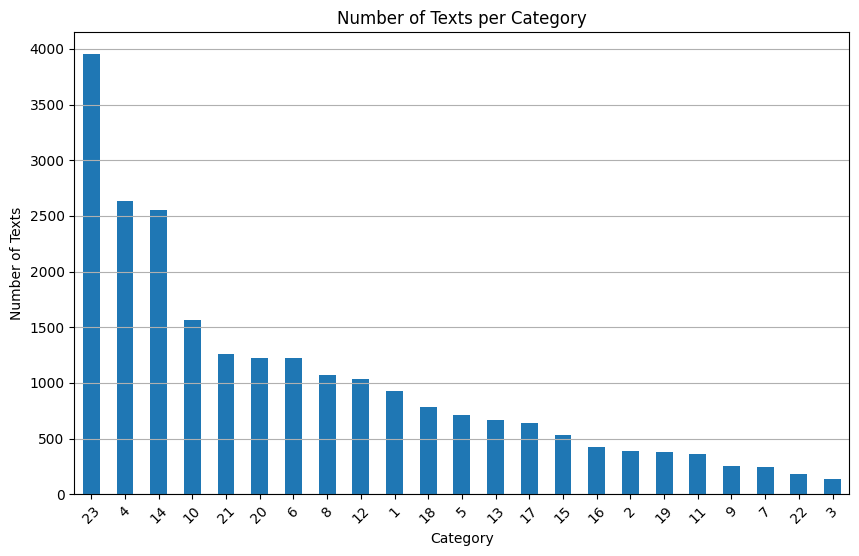

In [22]:
# Comptage du nombre de textes dans chaque catégorie.
category_counts = texts_df['Categorie'].value_counts()

# Préparation du graphique.
plt.figure(figsize=(10, 6))

# Création de l'histogramme.
category_counts.plot(kind='bar')

# Ajout du titre et des étiquettes pour les axes.
plt.title('Number of Texts per Category')
plt.xlabel('Category')
plt.ylabel('Number of Texts')

# Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité.
plt.xticks(rotation=45)

# Ajout d'une grille sur l'axe des y pour faciliter la lecture des valeurs.
plt.grid(axis='y')

# Affichage du graphique.
plt.show()

## Tokenisation et vectorisation

In [23]:
# Assurez-vous d'avoir les ressources NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')

# Nettoyage du texte
texts_df['Texte'] = texts_df['Texte'].str.lower().str.replace('[^\w\s]', '')

# Tokenisation
texts_df['Tokens'] = texts_df['Texte'].apply(nltk.word_tokenize)

# Suppression des stopwords
stop_words = set(stopwords.words('english'))
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Suppression des nombres
texts_df['Tokens'] = texts_df['Tokens'].apply(lambda x: [word for word in x if not word.isdigit()])

# Jointure des tokens pour reformer le texte
texts_df['Texte'] = texts_df['Tokens'].apply(lambda x: ' '.join(x))

# Stemming
stemmer = PorterStemmer()
texts_df['Stemmed'] = texts_df['Tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Vectorisation (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Vous pouvez ajuster le nombre de features
vectors = tfidf_vectorizer.fit_transform(texts_df['Texte'])

# Convertir les vecteurs TF-IDF en DataFrame pour une utilisation ultérieure
tfidf_df = pd.DataFrame(vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Affichage des premières lignes du DataFrame TF-IDF
tfidf_df.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yannpaillard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannpaillard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,000,0001,001,01,02,05,10,11,12,13,...,woman,women,work,would,wound,year,years,young,younger,yr
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.226075,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.079491,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.079302,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.086344,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.141094,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [24]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

"""
## Implement embedding layer

Two seperate embedding layers, one for tokens, one for token index (positions).
"""

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


Epoch 1/15
580/580 [==============================] - 18s 30ms/step - loss: 2.6253 - accuracy: 0.2301 - val_loss: 2.2686 - val_accuracy: 0.3280
Epoch 2/15
580/580 [==============================] - 18s 30ms/step - loss: 2.0677 - accuracy: 0.3806 - val_loss: 2.0714 - val_accuracy: 0.3731
Epoch 3/15
580/580 [==============================] - 18s 31ms/step - loss: 1.7649 - accuracy: 0.4546 - val_loss: 2.0895 - val_accuracy: 0.3580
Epoch 4/15
580/580 [==============================] - 19s 32ms/step - loss: 1.5817 - accuracy: 0.4904 - val_loss: 2.1591 - val_accuracy: 0.3274
Epoch 4: early stopping


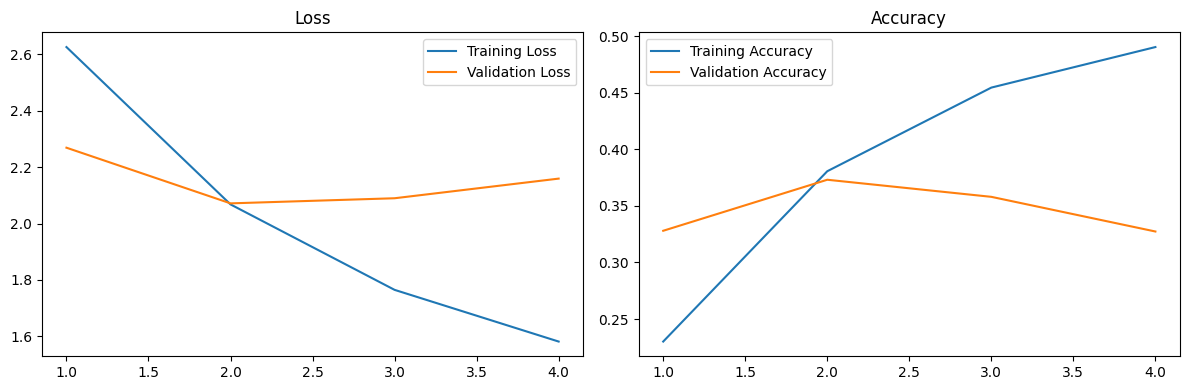

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

maxlen = 200
vocab_size = 20000
# Split the DataFrame into features (X) and labels (Y)
X = texts_df['Texte']
Y = texts_df['Categorie']

# Diviser les données en ensembles d'entraînement et de validation
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


# Tokenisation
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_val_sequences = tokenizer.texts_to_sequences(x_val)

# Padding
x_train_padded = pad_sequences(x_train_sequences, maxlen=maxlen, truncating='post')
x_val_padded = pad_sequences(x_val_sequences, maxlen=maxlen, truncating='post')

import numpy as np
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
"""
## Create classifier model using transformer layer

Transformer layer outputs one vector for each time step of our input sequence.
Here, we take the mean across all time steps and
use a feed forward network on top of it to classify text.
"""


embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(24, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


"""
## Train and Evaluate
"""

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    x_train_padded, y_train_np, batch_size=32, epochs=15, validation_data=(x_val_padded, y_val_np), callbacks = [early_stopping]
)

epochs_range = range(1, len(history.history['accuracy']) + 1)

# Configuration de la taille et du layout des graphiques.
plt.figure(figsize=(12, 4))

# Tracé de la perte d'entraînement et de validation.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Tracé de la précision d'entraînement et de validation.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Affichage des graphiques.
plt.tight_layout()
plt.show()


On remarque que le modèle commence à overfitter à partir de la 2ème époque. On peut donc arrêter l'entraînement à ce moment là.
La validation accuracy est de 0.37 et la validation loss est de 2.07.

# Exercise 2 : Explorer the transformers with Pytorch

cette section a pour but de montrer les possibilités offertes par la librairie transformers de Hugging Face. Nous allons donc explorer les différentes tâches de NLP que l'on peut effectuer avec cette librairie.

## Sentiment Analysis

In [26]:
classifier = pipeline('sentiment-analysis')
result = classifier("I love using transformers for NLP tasks!")
print(result)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

[{'label': 'POSITIVE', 'score': 0.9982925057411194}]


## Named Entity Recognition

In [27]:
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
model = AutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")

sequence = "Hugging Face Inc. is a company based in New York City. Its headquarters are in DUMBO, therefore very close to the Manhattan Bridge."

inputs = tokenizer(sequence, return_tensors="pt")
tokens = inputs.tokens()

outputs = model(**inputs).logits
predictions = torch.argmax(outputs, dim=2)

for token, prediction in zip(tokens, predictions[0].numpy()):
    print((token, model.config.id2label[prediction]))


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


('[CLS]', 'O')
('Hu', 'I-ORG')
('##gging', 'I-ORG')
('Face', 'I-ORG')
('Inc', 'I-ORG')
('.', 'O')
('is', 'O')
('a', 'O')
('company', 'O')
('based', 'O')
('in', 'O')
('New', 'I-LOC')
('York', 'I-LOC')
('City', 'I-LOC')
('.', 'O')
('Its', 'O')
('headquarters', 'O')
('are', 'O')
('in', 'O')
('D', 'I-LOC')
('##UM', 'I-LOC')
('##BO', 'I-LOC')
(',', 'O')
('therefore', 'O')
('very', 'O')
('close', 'O')
('to', 'O')
('the', 'O')
('Manhattan', 'I-LOC')
('Bridge', 'I-LOC')
('.', 'O')
('[SEP]', 'O')


## Question Answering

In [28]:
question_answerer = pipeline('question-answering')
context = "Hugging Face is a technology company based in New York and Paris"
result = question_answerer(question="Where is Hugging Face based?", context=context)
print(result)


No model was supplied, defaulted to distilbert-base-cased-distilled-squad and revision 626af31 (https://huggingface.co/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

{'score': 0.8231392502784729, 'start': 46, 'end': 64, 'answer': 'New York and Paris'}


## Text Generation

In [29]:
generator = pipeline('text-generation', model='gpt2')
result = generator("In today's world, technology is", max_length=50)
print(result[0]['generated_text'])


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In today's world, technology is transforming the world from the middle of nowhere away from every country to Asia. Technology has an impact on how countries use their resources, and by building networks of interdependencies, technology can become more integrated in the lives
